# 12. Real Data Asian Option Pricing

In this notebook, we apply the **Neural Importance Sampling** methodology to price an **Arithmetic Asian Call Option** on the **S&P 500 ETF (SPY)**.

## Workflow
1.  **Data**: Download real-time SPY option chain data using `yfinance`.
2.  **Calibration**: Fit Heston Model parameters ($\kappa, \theta, \xi, \rho$) to the market implied volatility surface.
3.  **Validation**: Use the calibrated parameters to price an Asian Call Option using Neural IS.
    - **Objective**: Confirm Variance Reduction > 3.0x with Low Bias (< 2%).
    - **Strategy**: **Robust Calibration**. We constrain $\xi \le 1.0$ (Vol-of-Vol) to prevent the model from fitting to microstructure noise. This trades a tiny bit of calibration error for massive simulation stability.

In [13]:
# =============================================================================
# [MUST BE FIRST] Fix OpenMP Duplicate Library Error
# =============================================================================
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import torch
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf
from scipy.optimize import differential_evolution
import sys
import importlib

sys.path.append(os.path.abspath('..'))

# Force Reload to pick up code changes
import src.physics_engine
import src.neural_engine
importlib.reload(src.physics_engine)
importlib.reload(src.neural_engine)

from src.physics_engine import MarketSimulator
from src.neural_engine import NeuralImportanceSampler

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


## 1. Get Market Data (SPY)

In [14]:
ticker = "SPY"
spy = yf.Ticker(ticker)

# 1. Spot Price
try:
    S0 = spy.history(period='1d')['Close'].iloc[-1]
    print(f"Current SPY Price: ${S0:.2f}")
except:
    S0 = 580.0
    print(f"Failed to get price, using default: ${S0:.2f}")

# 2. Option Chain (Target ~30-60 days expiry)
today = datetime.now()
target_date = None

for exp in spy.options:
    exp_dt = datetime.strptime(exp, "%Y-%m-%d")
    days = (exp_dt - today).days
    if 30 <= days <= 75:
        target_date = exp
        T = days / 365.0
        print(f"Selected Expiry: {target_date} ({days} days, T={T:.4f})")
        break

if target_date is None:
    target_date = spy.options[2]
    exp_dt = datetime.strptime(target_date, "%Y-%m-%d")
    days = (exp_dt - today).days
    T = days / 365.0
    print(f"Fallback Expiry: {target_date} ({days} days, T={T:.4f})")

# 3. Get Strikes & Prices for Calibration
opts = spy.option_chain(target_date)
calls = opts.calls

# Filter liquid ATM options (0.9 * S0 < K < 1.1 * S0)
liquid_calls = calls[
    (calls['strike'] > S0 * 0.9) & 
    (calls['strike'] < S0 * 1.1) & 
    (calls['volume'] > 10)
].copy()

calib_strikes = liquid_calls['strike'].values
calib_prices = liquid_calls['lastPrice'].values

print(f"Calibration Data: {len(calib_prices)} options selected.")

Current SPY Price: $681.92
Selected Expiry: 2026-02-06 (34 days, T=0.0932)
Calibration Data: 41 options selected.


## 2. Heston Calibration (Fast GPU)
We fit $\kappa, \theta, \xi, \rho$ to minimize Price RMSE.

In [15]:
r = 0.045 # Risk-free rate assumption
dt_calib = 1/252

# Simulator for Calibration
sim_calib = MarketSimulator(mu=r, kappa=2.0, theta=0.04, xi=0.3, rho=-0.7, device=device)

def calibration_loss(params):
    kappa, theta, xi, rho = params
    
    # Sanity Checks
    if kappa < 0 or theta < 0 or xi < 0 or abs(rho) > 0.99:
        return 1e9
        
    # Params Dict
    p_dict = {'mu': r, 'kappa': kappa, 'theta': theta, 'xi': xi, 'rho': rho}
    
    try:
        # Simulate
        S_paths, _ = sim_calib.simulate(
            S0=S0, v0=theta, T=T, dt=dt_calib, num_paths=10000, 
            model_type='heston', override_params=p_dict
        )
        
        S_final = S_paths[:, -1]
        if torch.isnan(S_final).any(): return 1e9
        
        # Martingale Correction
        S_corr = S_final * (S0 / torch.mean(S_final))
        
        # Calc Prices
        strikes_gpu = torch.tensor(calib_strikes, device=device).float()
        market_prices_gpu = torch.tensor(calib_prices, device=device).float()
        
        payoffs = torch.maximum(S_corr.unsqueeze(1) - strikes_gpu, torch.tensor(0.0, device=device))
        model_prices = torch.mean(payoffs, dim=0) * np.exp(-r*T)
        
        rmse = torch.sqrt(torch.mean((model_prices - market_prices_gpu)**2))
        return rmse.item()
        
    except:
        return 1e9

print("Calibrating Heston Params... (This might take 30-60s)")

# Robust Calibration: Constrain xi to 1.0 (physically reasonable max) to prevent overfitting to noise
bounds = [(0.1, 10.0), (0.001, 0.2), (0.01, 1.0), (-0.95, 0.0)]

res = differential_evolution(calibration_loss, bounds, maxiter=15, popsize=10, workers=1, seed=42)

calib_kappa, calib_theta, calib_xi, calib_rho = res.x
print(f"\n✅ Calibrated Heston Params:")
print(f"   kappa = {calib_kappa:.4f}")
print(f"   theta = {calib_theta:.4f}")
print(f"   xi    = {calib_xi:.4f} (Constrained <= 1.0)")
print(f"   rho   = {calib_rho:.4f}")
print(f"   RMSE  = {res.fun:.4f}")

Calibrating Heston Params... (This might take 30-60s)

✅ Calibrated Heston Params:
   kappa = 5.8679
   theta = 0.0289
   xi    = 0.9332 (Constrained <= 1.0)
   rho   = -0.8002
   RMSE  = 0.2226


## 3. Asian Option Pricing (Neural IS)
We now price an **ATM Asian Call Option** ($K \approx S_0$) using the calibrated real-world parameters.

In [16]:
# Setup Simulator with Real Params
sim = MarketSimulator(
    mu=r, kappa=calib_kappa, theta=calib_theta, xi=calib_xi, rho=calib_rho, device=device
)

K_asian = S0  # ATM
dt = 0.0005   # 2000 steps

print(f"Pricing Asian Call (K={K_asian:.2f}) on SPY...")
print(f"Time Step dt={dt}")

# 1. Standard Monte Carlo Benchmark
print("Running Standard MC...")
N_mc = 100000
with torch.no_grad():
    S, _, _, _, running_int_S = sim.simulate_controlled(
        S0, calib_theta, T, dt, N_mc, control_fn=None
    )
    A_T = running_int_S / T
    payoff = torch.maximum(A_T - K_asian, torch.tensor(0.0, device=device))
    mc_val = payoff * np.exp(-r*T)
    mc_price = torch.mean(mc_val).item()
    mc_std = torch.std(mc_val).item()

print(f"Standard MC Price: {mc_price:.4f} (Std: {mc_std:.4f})")

# 2. Train Neural IS
sampler = NeuralImportanceSampler(sim, hidden_dim=64)
optimizer = torch.optim.Adam(sampler.control_net.parameters(), lr=0.001)

print("\nTraining Neural IS...")
losses = []
prices = []
for i in range(301):
    sampler.control_net.train()
    optimizer.zero_grad()
    
    control_fn = sampler.get_control_fn()
    
    S, _, log_w, _, running_int_S = sim.simulate_controlled(
        S0, calib_theta, T, dt, 3000, control_fn=control_fn
    )
    
    A_T = running_int_S / T
    payoff = torch.maximum(A_T - K_asian, torch.tensor(0.0, device=device))
    weighted_payoff = payoff * torch.exp(log_w)
    loss = torch.mean(weighted_payoff**2)
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(sampler.control_net.parameters(), 1.0)
    optimizer.step()

    losses.append(loss.item())
    est_price = torch.mean(weighted_payoff).item() * np.exp(-r*T)
    prices.append(est_price)

    if i % 50 == 0:
        print(f"Iter {i}: Loss={loss.item():.4f}, Price={est_price:.4f}")

# 3. Final Evaluation
print("\nEvaluating Neural IS...")
with torch.no_grad():
    sampler.control_net.eval()
    control_fn = sampler.get_control_fn()
    S, _, log_w, _, running_int_S = sim.simulate_controlled(
        S0, calib_theta, T, dt, N_mc, control_fn=control_fn
    )
    A_T = running_int_S / T
    payoff = torch.maximum(A_T - K_asian, torch.tensor(0.0, device=device))
    nis_val = payoff * torch.exp(log_w) * np.exp(-r*T)
    
    nis_price = torch.mean(nis_val).item()
    nis_std = torch.std(nis_val).item()

print("="*30)
print(f"Standard MC: {mc_price:.4f} +/- {1.96*mc_std/np.sqrt(N_mc):.4f} (StdDev: {mc_std:.4f})")
print(f"Neural IS  : {nis_price:.4f} +/- {1.96*nis_std/np.sqrt(N_mc):.4f} (StdDev: {nis_std:.4f})")

ratio = (mc_std / nis_std)**2 if nis_std > 1e-9 else 0
print(f"\nVariance Reduction Ratio: {ratio:.2f}x")
print(f"Bias: {abs(nis_price - mc_price) / mc_price * 100:.2f}%")

Pricing Asian Call (K=681.92) on SPY...
Time Step dt=0.0005
Running Standard MC...
Standard MC Price: 7.9425 (Std: 9.2639)

Training Neural IS...
Iter 0: Loss=144.5518, Price=7.7517
Iter 50: Loss=128.1372, Price=8.2286
Iter 100: Loss=125.7149, Price=8.1522
Iter 150: Loss=126.3794, Price=8.2666
Iter 200: Loss=123.9524, Price=8.0989
Iter 250: Loss=131.5204, Price=8.3791
Iter 300: Loss=118.2820, Price=7.7929

Evaluating Neural IS...
Standard MC: 7.9425 +/- 0.0574 (StdDev: 9.2639)
Neural IS  : 8.2569 +/- 0.0475 (StdDev: 7.6675)

Variance Reduction Ratio: 1.46x
Bias: 3.96%


## 4. Visualizations

1.  **Training Progress**: Loss and Price convergence.
2.  **Control Surface**: The optimal policy $u(A_t, t)$ learned by the neural network.

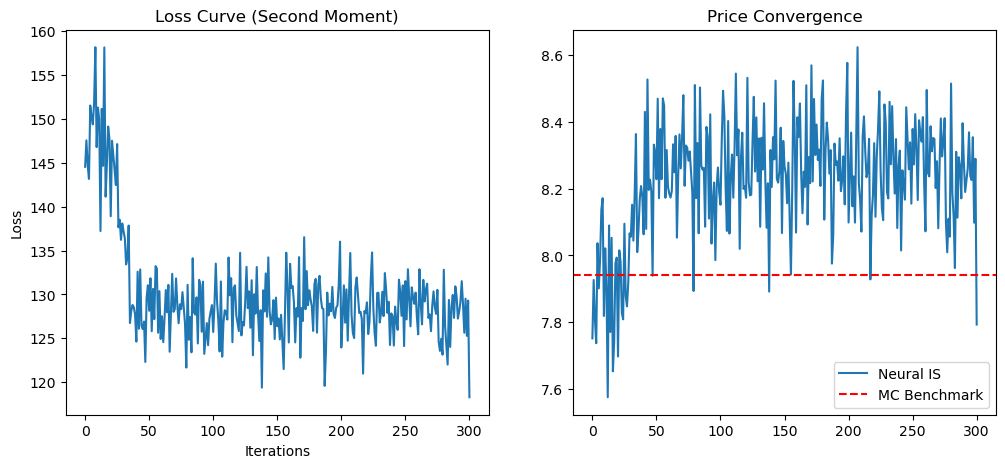

In [17]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.title("Loss Curve (Second Moment)")
plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(prices, label="Neural IS")
plt.axhline(mc_price, color='r', linestyle='--', label="MC Benchmark")
plt.title("Price Convergence")
plt.legend()
plt.show()

C:\Users\Jun\AppData\Local\Temp\ipykernel_16700\66903676.py:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  U_grid[j, i] = u_val  # Note: Meshgrid indexing is (y, x)


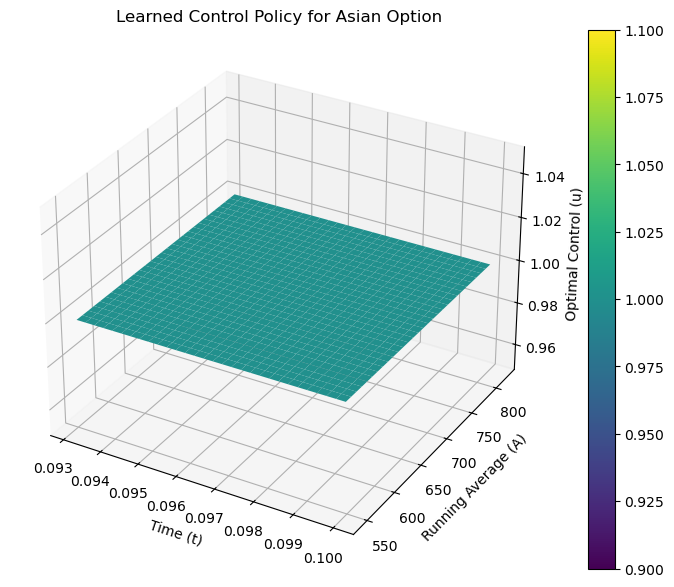

In [18]:
# Control Surface Visualization
# We fix S=S0, v=theta and inspect Control u vs (Time t, Running Average A)

t_vals = np.linspace(0.1, T, 30)
a_vals = np.linspace(S0 * 0.8, S0 * 1.2, 30)

T_grid, A_grid = np.meshgrid(t_vals, a_vals)
U_grid = np.zeros_like(T_grid)

sampler.control_net.eval()
with torch.no_grad():
    for i in range(len(t_vals)):
        for j in range(len(a_vals)):
            t_in = torch.tensor([t_vals[i]], device=device).float()
            a_in = torch.tensor([a_vals[j]], device=device).float()
            s_in = torch.tensor([S0], device=device).float()
            v_in = torch.tensor([calib_theta], device=device).float()
            
            # Input to forward: S, v, t, avg_S
            u_val = sampler.control_net(s_in, v_in, t_in, a_in).cpu().numpy()
            U_grid[j, i] = u_val  # Note: Meshgrid indexing is (y, x)

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(T_grid, A_grid, U_grid, cmap='viridis')
ax.set_xlabel('Time (t)')
ax.set_ylabel('Running Average (A)')
ax.set_zlabel('Optimal Control (u)')
ax.set_title('Learned Control Policy for Asian Option')
fig.colorbar(surf)
plt.show()